In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
# Import Sentiment140 dataset
# Update file location of Sentiment140.csv according to your working environment

data_path  = "data/training.1600000.processed.noemoticon.csv"

twitter_data = pd.read_csv(data_path,names=['target','id','date','flag','user','text'],
                           encoding = "ISO-8859-1")

In [5]:
# Create NumPy array of unprocessed input text and target 

X=np.array(twitter_data['text'])
Y=np.array(twitter_data['target'])

# Set Y=1 for Positive Tweets
Y[Y==4]=1

In [6]:
# Visualize Dataset

index = 123  # index in range [0,1599999]

print(X[index])

I am in pain. My back and sides hurt. Not to mention crying is made of fail. 


In [7]:
# Define Preprocessing functions

def tokenize(X):
  """
  Tokenize the data using nltk
  """

  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized


def remove_stopwords(X):
  """
  Remove Stopwords using nltk
  """

  stopwords=nltk.corpus.stopwords.words('english') + ['@']
  X_without_stopwords = []

  for sentence in X:

    temp = [word for word in sentence if not word in stopwords]
    X_without_stopwords.append(temp) 

  return X_without_stopwords


def stem(X,type='porter'):
  """
  Perform Stemming using nltk
  type = 'Porter','Snowball','Lancaster'
  """
  
  if type == 'porter':
    stemmer= nltk.stem.PorterStemmer()
  elif type == 'snowball':
    stemmer = nltk.stem.SnowballStemmer()
  elif type == 'lancaster':
    stemmer = nltk.stem.LancasterStemmer()    

  
  X_stemmed = []

  for sentence in X:

    temp = [stemmer.stem(word) for word in sentence]
    X_stemmed.append(temp)

  return X_stemmed 



def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized    

# **Training on Pre-Processed data with GloVe Word Embeddings**



In [8]:
# Preprocess the data

X_tokenized = tokenize (X)

X_without_stopwords = remove_stopwords ( X_tokenized )

X_lemmatized = lemmatize ( X_without_stopwords )

X_clean = []

for sentence in X_lemmatized:

  temp = " ".join(sentence)
  X_clean.append(temp)

In [9]:
# Count total no. of distinct tokens

tokenizer = Tokenizer(filters='@')
tokenizer.fit_on_texts(X_clean)

print('No. of distinct tokens = '+str(len(tokenizer.word_index)))

No. of distinct tokens = 836890


In [10]:
# Define Vocabulary size (no. of most frequent tokens) to consider

max_vocab=50000

In [11]:
# Reload Twitter dataset with new Vocabulary

tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(X_clean)

In [12]:
# Vectorize input text using Vocabulary

X_clean_vectorized=tokenizer.texts_to_sequences(X_clean)

In [13]:
# Count average length of tweets

length=[]
for sentence in X_clean_vectorized:
  length.append(len(sentence))
  
print('Average length of tweets = '+str(np.mean(length)))

Average length of tweets = 10.061133125


In [14]:
# Define Maximum input length of the Model

max_length=20

In [15]:
# Pad or Trim data to defined input length

X_clean_pad = keras.preprocessing.sequence.pad_sequences(X_clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(X_clean_pad.shape)

(1600000, 20)


In [16]:
# Visualize pre-processed data

index  = 123  # index in range [0,1599999]

print('\nOriginal :')
print(X[index])
print('\nTokenized :')
print(X_tokenized[index])
print('\nStopwords removed :')
print(X_without_stopwords[index])
print('\nPOS tagged :')
print(nltk.pos_tag(X_without_stopwords[index]))
print('\nLemmatized :')
print(X_lemmatized[index])
print('\nClean :')
print(X_clean[index])
print('\nVectorized :')
print(X_clean_vectorized[index])
print('\nPadded :')
print(X_clean_pad[index])


Original :
I am in pain. My back and sides hurt. Not to mention crying is made of fail. 

Tokenized :
['I', 'am', 'in', 'pain.', 'My', 'back', 'and', 'sides', 'hurt.', 'Not', 'to', 'mention', 'crying', 'is', 'made', 'of', 'fail', '.']

Stopwords removed :
['I', 'pain.', 'My', 'back', 'sides', 'hurt.', 'Not', 'mention', 'crying', 'made', 'fail', '.']

POS tagged :
[('I', 'PRP'), ('pain.', 'VBP'), ('My', 'PRP$'), ('back', 'NN'), ('sides', 'NNS'), ('hurt.', 'VBP'), ('Not', 'RB'), ('mention', 'NN'), ('crying', 'VBG'), ('made', 'VBN'), ('fail', 'NN'), ('.', '.')]

Lemmatized :
['I', 'pain.', 'My', 'back', 'side', 'hurt.', 'Not', 'mention', 'cry', 'make', 'fail', '.']

Clean :
I pain. My back side hurt. Not mention cry make fail .

Vectorized :
[2, 3428, 62, 30, 591, 4229, 146, 831, 308, 33, 426, 4]

Padded :
[   2 3428   62   30  591 4229  146  831  308   33  426    4    0    0
    0    0    0    0    0    0]


In [17]:
# Perform train-test split

np.random.seed(123)

X_train, X_test, Y_train, Y_test = train_test_split (X_clean_pad,Y.reshape(Y.shape[0],1),test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1440000, 20)
(160000, 20)
(1440000, 1)
(160000, 1)


In [18]:
vocab_size = 5000  # Only consider the top 20k words
num_tokens_per_example = 20 
embed_dim = 32  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 10  # Number of experts used in the Switch Transformer.
batch_size = 32  # Batch size.
learning_rate = 0.001  # Learning rate.
dropout_rate = 0.25  # Dropout rate.
num_epochs = 25  # Number of epochs.
num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.
print(f"Number of tokens per batch: {num_tokens_per_batch}")


Number of tokens per batch: 640


In [19]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        return super(TransformerBlock,self).get_config()

In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    def get_config(self):
        return super(TokenAndPositionEmbedding,self).get_config()

In [29]:
maxlen=20
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
transformer_block3 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)
x = transformer_block2(x)
x = transformer_block3(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
token_and_position_embedding (None, 20, 32)            160640    
_________________________________________________________________
transformer_block_6 (Transfo (None, 20, 32)            10656     
_________________________________________________________________
transformer_block_7 (Transfo (None, 20, 32)            10656     
_________________________________________________________________
transformer_block_8 (Transfo (None, 20, 32)            10656     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0   

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from focal_loss import BinaryFocalLoss
model.compile(optimizer = "adam", loss = BinaryFocalLoss(gamma=2), metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('models/trans.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train,Y_train,batch_size=640,epochs=25,validation_split=0.2,callbacks=[es, mc])

Epoch 1/25
1800/1800 [==============================] - 171s 93ms/step - loss: 0.1251 - accuracy: 0.7633 - val_loss: 0.1199 - val_accuracy: 0.7787

Epoch 00001: val_accuracy improved from -inf to 0.77872, saving model to models\trans.h5
Epoch 2/25
1800/1800 [==============================] - 152s 84ms/step - loss: 0.1182 - accuracy: 0.7824 - val_loss: 0.1169 - val_accuracy: 0.7826

Epoch 00002: val_accuracy improved from 0.77872 to 0.78261, saving model to models\trans.h5
Epoch 3/25
1800/1800 [==============================] - 157s 87ms/step - loss: 0.1163 - accuracy: 0.7863 - val_loss: 0.1166 - val_accuracy: 0.7850

Epoch 00003: val_accuracy improved from 0.78261 to 0.78495, saving model to models\trans.h5
Epoch 4/25
1800/1800 [==============================] - 155s 86ms/step - loss: 0.1148 - accuracy: 0.7896 - val_loss: 0.1163 - val_accuracy: 0.7857

Epoch 00004: val_accuracy improved from 0.78495 to 0.78571, saving model to models\trans.h5
Epoch 5/25
1800/1800 [=====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


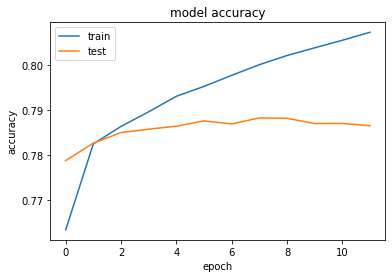

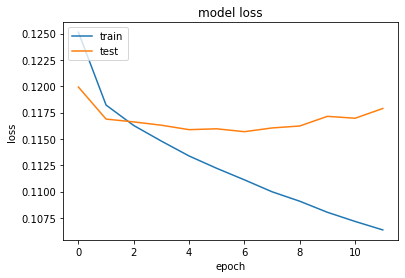

In [31]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.save('models/trans.tf')


INFO:tensorflow:Assets written to: models/trans.tf\assets


INFO:tensorflow:Assets written to: models/trans.tf\assets


In [43]:
from focal_loss import BinaryFocalLoss
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model('models/trans.tf')

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

yhat1 = model.predict(X_test, verbose=0)

#Binary Classification
yhat=np.where(yhat1 > 0.5, 1,0)

#Mutli-class Classification
#yhat = np.argmax(yhat, axis = 1)


accuracy = accuracy_score( Y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(Y_test, yhat)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Y_test, yhat1)
print('ROC AUC: %f' % auc)


Accuracy: 0.786125
Precision: 0.781555
Recall: 0.793891
F1 score: 0.787675
Cohens kappa: 0.572254
ROC AUC: 0.869411


In [45]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [46]:
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

20/20 [==============================] - 5s 246ms/step


In [47]:
y_test_1d = [decode_sentiment(score, include_neutral=False) for score in y_test_1d]

In [48]:
import itertools
from sklearn.metrics import classification_report

In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    labels=['Negative','Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels, rotation=90, fontsize=22)
    plt.yticks(tick_marks, labels, fontsize=22)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

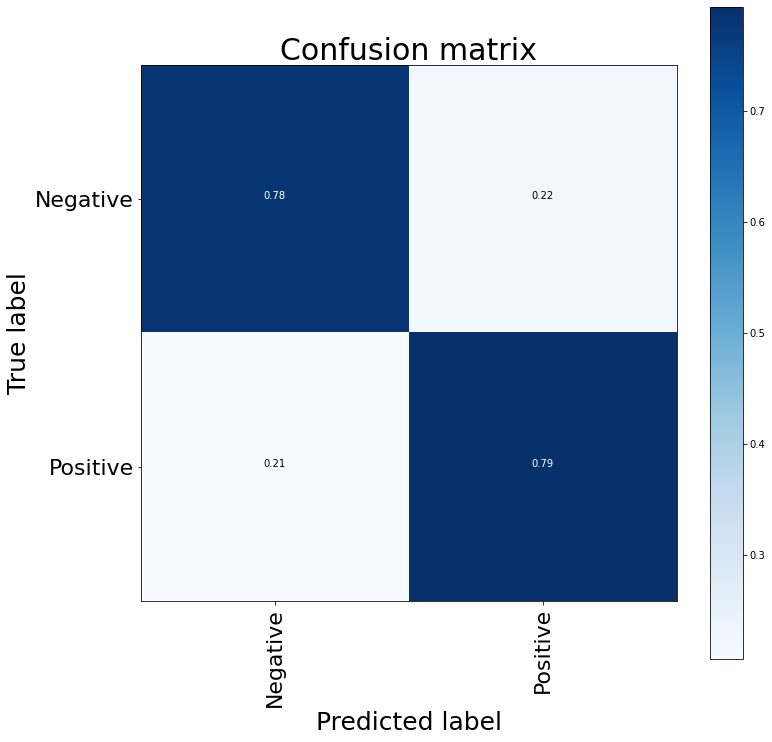

In [50]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=twitter_data.target.unique(), title="Confusion matrix")
plt.show()

In [51]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.78     80047
    POSITIVE       0.78      0.79      0.79     79953

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



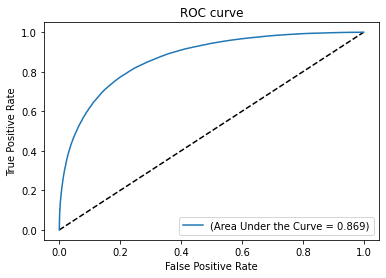

In [52]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(Area Under the Curve = {:.3f})'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ('ROC curve')
plt.legend(loc='best')
plt.show()